In [1]:
import torchvision 
import torch.nn as nn 
import torch 
import torch.nn.functional as F 
from torchvision import transforms,models,datasets 
import matplotlib.pyplot as plt 
from PIL import Image 
import numpy as np 
from torch import optim 

from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
import pandas as pd
import seaborn as sns

In [3]:
np.random.seed(0)
torch.manual_seed(0)

In [2]:
data_dir = "D:/DatasetsCD/binary_classification_covid_dataset"

transform = transforms.Compose([transforms.Resize(255), 
    transforms.CenterCrop(224), 
    transforms.RandomHorizontalFlip(),                            
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])]) 

dataset = torchvision.datasets.ImageFolder(data_dir, transform= transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=32 ,shuffle=True) 

In [3]:
inputs, classes = next(iter(train_loader))  
inputs.shape,classes.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [5]:
dataset.class_to_idx
idx2class = {v: k for k, v in dataset.class_to_idx.items()}
idx2class

{0: 'COVID', 1: 'NORMAL'}

In [9]:
idx2class = {v: k for k, v in dataset.class_to_idx.items()}

def get_class_distribution(dataset_obj):
    
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
    
    return count_dict

print("Distribution of classes: \n", get_class_distribution(dataset))

Distribution of classes: 
 {'COVID': 1200, 'NORMAL': 1341}


In [10]:
## spliting dataset 80 % training,20 % VALIDATION 
train_dataset, val_dataset = random_split(dataset,(2000,541))

In [11]:
training_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=32)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=1)

print("Length of the train_loader:", len(training_loader))
print("Length of the val_loader:", len(val_loader))

Length of the train_loader: 63
Length of the val_loader: 541


In [12]:
single_batch = next(iter(training_loader))
single_batch[0].shape
print("\nOutput label tensor : ", single_batch[1])



Output label tensor :  tensor([1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
        1, 0, 0, 0, 1, 1, 1, 1])


In [2]:

device = torch.device("cuda:0")
if torch.cuda.is_available():
    device = torch.device("cuda:0")  #
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [3]:
##defining model res net 50

model = models.resnet50(pretrained=True).to(device) # freeze all the parameters except the final layer 
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 1),
               nn.Sigmoid()).to(device)
#print(model)

In [15]:
import torch.optim as optim


criterion = nn.BCELoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)




In [16]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)
    
    correct_result_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_result_sum/y_test.shape[0]
    acc  = torch.round(acc*100)
    
    return acc
    

In [17]:
## one neurone output and sigmoid, BCELOO

print("Begin training...")

accuracy_stats = {
    'train': [],
    "val": []
             }
loss_stats = {
    'train': [],
    "val": []
             }
Epochs= 10

for epoch in range(Epochs):
    #training
    
    train_epoch_loss = 0
    train_epoch_acc  = 0
    
    model.train()
    for X_train_batch, y_train_batch in training_loader:
        y_train_batch = y_train_batch.to(torch.float32)
        X_train_batch , y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        
        optimizer.zero_grad()
        
        y_train_pred  = model(X_train_batch)
        
        train_loss = criterion( y_train_pred,y_train_batch.unsqueeze(1))
        train_acc = binary_acc(y_train_pred,y_train_batch.unsqueeze(1))
        
        train_loss.backward() #omputes dloss/dx for every parameter x
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    #Testing
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
    
        for X_val_batch, y_val_batch in val_loader:
            y_val_batch = y_val_batch.to(torch.float32)
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)
            

            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            val_acc = binary_acc(y_val_pred, y_val_batch.unsqueeze(1))

            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
        
    loss_stats['train'].append(train_epoch_loss/len(training_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(training_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader)) 
            
    print(f"Epoch: {epoch}| train-loss: {train_epoch_loss/len(training_loader)}| val-loss: {val_epoch_loss/len(val_loader)} | train_accuracy : {train_epoch_acc/len(training_loader)} | val_accuracy : {val_epoch_acc/len(val_loader)} ")
      

Begin training...
Epoch: 0| train-loss: 0.15294868093989197| val-loss: 0.028038843325181903 | train_accuracy : 94.65079365079364 | val_accuracy : 99.44547134935306 
Epoch: 1| train-loss: 0.0336017503794874| val-loss: 0.019166143904201977 | train_accuracy : 99.0952380952381 | val_accuracy : 99.44547134935306 
Epoch: 2| train-loss: 0.055307376730654924| val-loss: 0.01607956300571406 | train_accuracy : 98.42857142857143 | val_accuracy : 99.63031423290204 
Epoch: 3| train-loss: 0.03833847911104501| val-loss: 0.04053773684729757 | train_accuracy : 98.80952380952381 | val_accuracy : 98.8909426987061 
Epoch: 4| train-loss: 0.051060541146730504| val-loss: 0.015914510383345303 | train_accuracy : 98.42857142857143 | val_accuracy : 99.44547134935306 
Epoch: 5| train-loss: 0.03427550588533031| val-loss: 0.015118205021739347 | train_accuracy : 98.71428571428571 | val_accuracy : 99.63031423290204 
Epoch: 6| train-loss: 0.09834087254398222| val-loss: 0.015371531427429093 | train_accuracy : 97.0952380

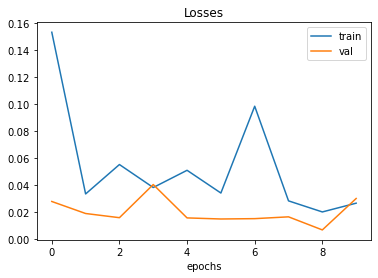

In [18]:
for v,c in sorted(loss_stats.items()):
    plt.plot(c,label=v)
plt.xlabel('epochs')
plt.title('Losses')
plt.legend()
plt.show()
#plt.plot(loss

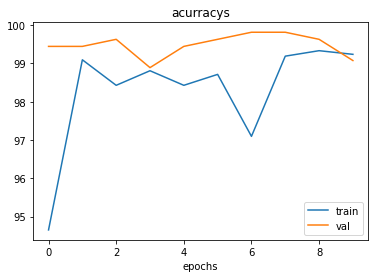

In [19]:
for v,c in sorted(accuracy_stats.items()):
    plt.plot(c,label=v)
plt.xlabel('epochs')
plt.title('acurracys')
plt.legend()
plt.show()

In [20]:
torch.save(model.state_dict(), 'model_weights.pth')

In [4]:
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
#preparing test data 
data_dir = "D:\DatasetsCD\Test_set"


transforms2 = transforms.Compose([transforms.Resize((224,224)),
                                  
                                  transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                       std=[0.229, 0.224, 0.225])
                                                           ])

dataset2 =datasets.ImageFolder(data_dir, transform= transforms2)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1 ,shuffle=True) 


In [6]:
len(test_loader)
dataset2.class_to_idx

{'COVID': 0, 'NORMAL': 1}

In [7]:
len(test_loader)

606

In [55]:
batch = next(iter(test_loader))


In [24]:
count_covid = 0
count_normal  =0

for i in range(y_true_list.shape[0]):
    if y_true_list[i] ==0:
        count_covid+=1
    else:
        count_normal+=1
print("number of covid patient:",count_covid)
print("number of covid patient:",count_normal)

NameError: name 'y_true_list' is not defined

In [8]:

y_true =[]
y_predicted = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x,batch_y = batch_x.to(device),batch_y.to(device)
        
        y_test_pred = model(batch_x)
        y_pred_tag = torch.round(y_test_pred)
        
       
        y_predicted.append(y_pred_tag.cpu().numpy())
        y_true.append(batch_y.cpu().numpy())
 

In [9]:
y_predicted = np.array(y_predicted)
y_predicted = y_predicted.reshape(606,)

y_true =  np.array(y_true)
y_true = y_true.reshape(606,)



In [11]:
from sklearn.metrics import confusion_matrix, classification_report


conf = confusion_matrix(y_predicted,y_true)
conf

array([[331,   0],
       [ 35, 240]], dtype=int64)

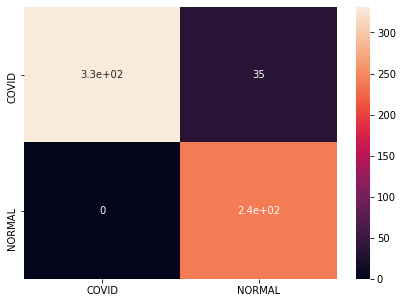

In [12]:
idx2class = {v: k for k, v in dataset2.class_to_idx.items()}
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, y_predicted)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)

In [50]:
print(classification_report(y_predicted, y_true))

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95       331
         1.0       1.00      0.87      0.93       275

    accuracy                           0.94       606
   macro avg       0.95      0.94      0.94       606
weighted avg       0.95      0.94      0.94       606



Text(0, 0.5, 'True Positive Rate')

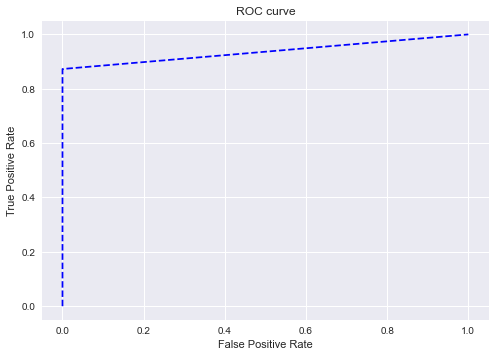

In [51]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_predicted,y_true, pos_label = 1)

import matplotlib.pyplot as plt 
plt.style.use('seaborn')

plt.plot(fpr,tpr,  linestyle = '--', color = 'blue', label = 'ResNet54')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 